In [3]:
import pandas as pd
df_samples = pd.read_csv('data.csv')

df_samples.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [9]:
df_filtered = df_samples[['filename', 'tempo', 'beats', 'label']]

df_filtered = df_filtered.rename(columns={
    'filename': 'Name',
    'tempo': 'Tempo',
    'beats': 'Beats',
    'label': 'Genre',
})
df_filtered.head()

,Name,Tempo,Beats,Genre
0,blues.00081.au,103.359375,50,blues
1,blues.00022.au,95.703125,44,blues
2,blues.00031.au,151.999081,75,blues
3,blues.00012.au,184.570312,91,blues
4,blues.00056.au,161.499023,74,blues


# Average Tempo of each Label/Genre

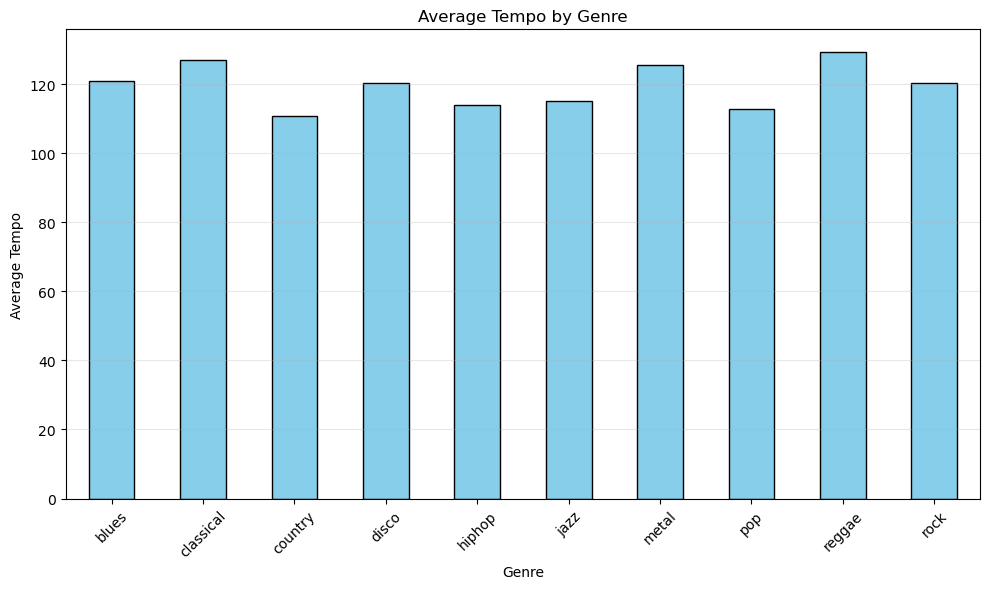

In [15]:
import matplotlib.pyplot as plt

average_tempo = df_filtered.groupby('Genre')['Tempo'].mean()


plt.figure(figsize=(10, 6))
average_tempo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Tempo by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Tempo')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Average Beats of each Label/Genre

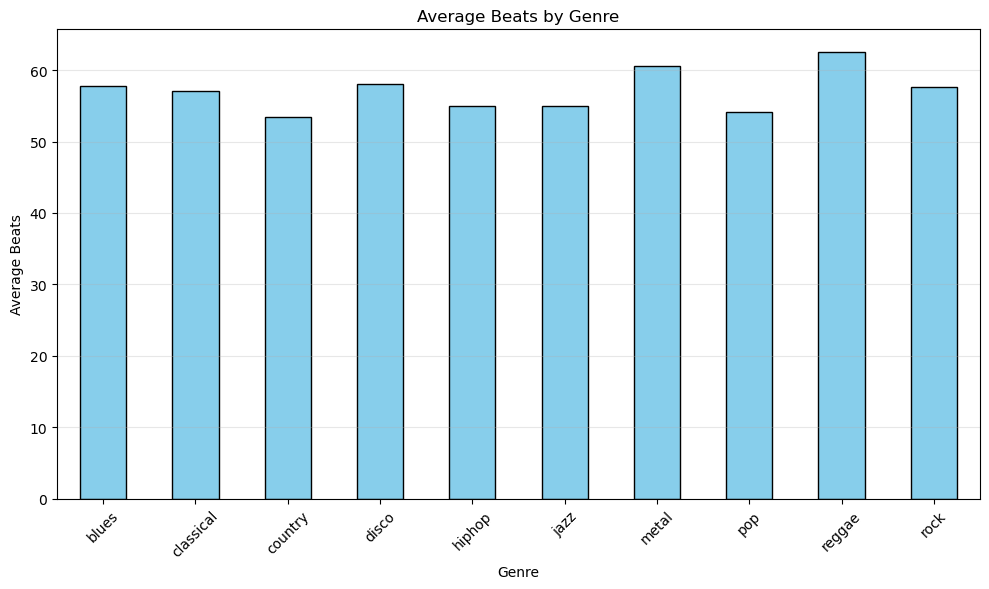

In [16]:
average_tempo = df_filtered.groupby('Genre')['Beats'].mean()


plt.figure(figsize=(10, 6))
average_tempo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Beats by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Beats')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

We would expect the average beats to correlate to the average tempo of each genre, we test that here

In [17]:
from scipy.stats import pearsonr, spearmanr

average_values = df_filtered.groupby('Genre')[['Tempo', 'Beats']].mean()

pearson_corr, pearson_p = pearsonr(average_values['Tempo'], average_values['Beats'])

spearman_corr, spearman_p = spearmanr(average_values['Tempo'], average_values['Beats'])

print(f"Pearson Correlation: {pearson_corr:.2f}, P-value: {pearson_p:.4f}")
print(f"Spearman Correlation: {spearman_corr:.2f}, P-value: {spearman_p:.4f}")

Pearson Correlation: 0.91, P-value: 0.0003
Spearman Correlation: 0.85, P-value: 0.0016


The small p value indicates a significant correlation between tempo and beats